# Import libraries

In [4]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision import transforms

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from tqdm import tqdm
from IPython.display import clear_output

from random import randint

In [5]:
np.random.seed(42)

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

# Loading data & preprocessing

In [6]:
path_to_data = './../../data/ftir_data/ftir_scaled.csv'
path_to_description = './../../data/ftir_data/ftir_description.csv'

In [7]:
# reading data
data_scaled = pd.read_csv(path_to_data)

# setting indexes
data_scaled.index = data_scaled.iloc[:, 0].tolist()
data_scaled.index.values[1:] = data_scaled.index.values[1:].astype(int)

# deleting useless column
if 'Unnamed: 0' in data_scaled.columns:
    data_scaled = data_scaled.drop(columns=['Unnamed: 0'])

data_scaled.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141
wavenumber,1900.766600,1899.802230,1898.837870,1897.873500,1896.909130,1895.944770,1894.980400,1894.016030,1893.051670,1892.087300,1891.122930,1890.158570,1889.194200,1888.229830,1887.265470,1886.301100,1885.336730,1884.372370,1883.408000,1882.44364,1881.479270,1880.514900,1879.550540,1878.586170,1877.621800,...,823.569090,822.604720,821.640360,820.675990,819.711620,818.747260,817.782890,816.818520,815.854160,814.889790,813.925420,812.961060,811.996690,811.032320,810.067960,809.103590,808.139230,807.174860,806.210490,805.246130,804.281760,803.317390,802.353030,801.388660,800.424290
1,0.000494,0.000944,0.001362,0.001750,0.002112,0.002451,0.002770,0.003074,0.003364,0.003646,0.003921,0.004193,0.004467,0.004744,0.005028,0.005324,0.005633,0.005960,0.006308,0.00668,0.007079,0.007509,0.007974,0.008476,0.009019,...,0.037121,0.035323,0.033560,0.031835,0.030152,0.028514,0.026926,0.025390,0.023910,0.022491,0.021135,0.019846,0.018627,0.017483,0.016417,0.015433,0.014533,0.013723,0.013004,0.012382,0.011859,0.011440,0.011127,0.010924,0.010836
2,0.000210,0.000215,0.000213,0.000205,0.000192,0.000175,0.000155,0.000132,0.000109,0.000085,0.000063,0.000042,0.000025,0.000011,0.000003,0.000000,0.000004,0.000017,0.000039,0.00007,0.000113,0.000168,0.000236,0.000318,0.000415,...,0.072690,0.071565,0.070364,0.069083,0.067721,0.066275,0.064743,0.063123,0.061413,0.059610,0.057713,0.055719,0.053626,0.051432,0.049135,0.046732,0.044221,0.041600,0.038868,0.036021,0.033058,0.029976,0.026773,0.023447,0.019997


In [8]:
# reading data
samples_description = pd.read_csv(path_to_description)

# setting indexes
samples_description.index = samples_description.iloc[:, 0].tolist()
samples_description.index.values[1:] = samples_description.index.values[1:].astype(int)

# deleting useless column
if 'Unnamed: 0' in samples_description.columns:
    samples_description = samples_description.drop(columns=['Unnamed: 0'])

samples_description.head(3)

,Description,Type,Class
1,"MFGO, разб. 1:20",$GO$,1
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1


In [9]:
wavenumber = data_scaled.iloc[0]
data = data_scaled.iloc[1:, :]

# selecting only go data
go_indexes = samples_description.loc[samples_description['Type'] == '$GO$'].index
go_data = data.loc[go_indexes]

# selecting only go dialysis data
god_indexes = samples_description.loc[samples_description['Type'] == '$GO_{d}$'].index
god_data = data.loc[god_indexes]

# selecting only rgo data
rgo_indexes = samples_description.loc[samples_description['Type'] == '$rGO$'].index
rgo_data = data.loc[rgo_indexes]

# Data processing

## Augmentation

In [44]:
%%time

if 'augmented_data.csv' in os.listdir('./../../data/ftir_data'):
    data_aug = pd.read_csv('./../../data/ftir_data/augmented_data.csv')
    if 'Unnamed: 0' in data_aug.columns:
        data_aug = data_aug.drop(columns=['Unnamed: 0'])
else:
    # base parameters for augmentation
    aug_factor = 100
    min_sigma = 5e-4
    max_sigma = 1e-2

    # data augmentation
    data_aug = data.copy()
    for idx in tqdm(data.index):
        spectrum = data.loc[idx]
        sigma_values = np.linspace(min_sigma, max_sigma, aug_factor)
        for sigma in sigma_values:
            noised_spectrum = pd.DataFrame(spectrum + np.random.normal(0, sigma, spectrum.shape[0]))
            data_aug = pd.concat([data_aug, noised_spectrum.T], axis=0)

    # scaling
    scaler = MinMaxScaler()
    data_aug = pd.DataFrame(scaler.fit_transform(data_aug.T).T)

    data_aug.to_csv('./../../data/ftir_data/augmented_data.csv')

print(data_aug.shape)
data_aug.sample(3)

(2525, 1142)
CPU times: user 2.71 s, sys: 198 ms, total: 2.91 s
Wall time: 3.02 s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141
2291,0.057517,0.045591,0.034745,0.053430,0.044769,0.030804,0.036154,0.040805,0.038241,0.041298,0.039151,0.030330,0.027430,0.039189,0.037142,0.034081,0.039341,0.030710,0.027707,0.028384,0.026759,0.028604,0.029850,0.032038,0.025551,...,0.029660,0.048168,0.041307,0.037062,0.029229,0.030288,0.035288,0.035630,0.024433,0.035903,0.027369,0.022710,0.028596,0.030145,0.036454,0.022151,0.024787,0.023643,0.018769,0.019455,0.021023,0.018500,0.012252,0.020453,0.000000
1581,0.006702,0.017940,0.006421,0.011516,0.012580,0.009316,0.015950,0.009772,0.010174,0.004910,0.013617,0.003484,0.012503,0.019084,0.009976,0.003592,0.015527,0.008184,0.009318,0.004790,0.001438,0.004736,0.011340,0.009661,0.010808,...,0.093663,0.071367,0.072223,0.078605,0.072192,0.079218,0.079852,0.079007,0.071110,0.054725,0.069572,0.059753,0.063829,0.072527,0.059488,0.052482,0.058666,0.064552,0.055389,0.048587,0.057200,0.047580,0.054900,0.057428,0.058241
1115,0.026148,0.035264,0.018859,0.038627,0.024668,0.034769,0.051642,0.027551,0.026352,0.030057,0.031949,0.018756,0.031097,0.019965,0.039916,0.023025,0.026048,0.032326,0.017565,0.029239,0.034720,0.023443,0.020409,0.022410,0.019459,...,0.081537,0.057897,0.063621,0.073291,0.058276,0.070087,0.053788,0.062205,0.073198,0.071876,0.056001,0.064547,0.075603,0.072925,0.070992,0.063331,0.061276,0.056729,0.055488,0.056695,0.053742,0.073518,0.041218,0.059735,0.046177


## Splitting data to train/validation

In [63]:
train_data, val_data = train_test_split(data_aug, test_size=0.2,)

print(train_data.shape, val_data.shape, sep='\n')

(2020, 1142)
(505, 1142)


## Creating *torch tensor* & *torch dataset*

In [64]:
go_data_torch = torch.Tensor([go_data.to_numpy()])
god_data_torch = torch.Tensor([god_data.to_numpy()])
rgo_data_torch = torch.Tensor([rgo_data.to_numpy()])

train_data_torch = torch.Tensor([train_data.to_numpy()])
val_data_torch = torch.Tensor([val_data.to_numpy()])

print(train_data_torch.shape, val_data_torch.shape, sep='\n')

torch.Size([1, 2020, 1142])
torch.Size([1, 505, 1142])


In [65]:
go_data_torch = go_data_torch.permute(1, 0, 2)
god_data_torch = god_data_torch.permute(1, 0, 2)
rgo_data_torch = rgo_data_torch.permute(1, 0, 2)

train_data_torch = train_data_torch.permute(1, 0, 2)
val_data_torch = val_data_torch.permute(1, 0, 2)

print(train_data_torch.shape, val_data_torch.shape, sep='\n')

torch.Size([2020, 1, 1142])
torch.Size([505, 1, 1142])


In [67]:
train_dataset = TensorDataset(train_data_torch, train_data_torch)
val_dataset = TensorDataset(val_data_torch, val_data_torch)

## Creating *dataloader*

In [68]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)

# Autoencoder model construction

## Encoder block

In [69]:
def encoder_block(in_channels,
                  out_channels,
                  kernel_size,
                  padding):
    block = nn.Sequential(
        nn.Conv1d(in_channels=in_channels,
                  out_channels=out_channels,
                  kernel_size=kernel_size,
                  padding=padding),
        nn.Sigmoid(),
        nn.MaxPool1d(kernel_size=2)
    )
    return block

## Decoder block

In [70]:
def decoder_block(in_channels,
                  out_channels,
                  kernel_size,
                  padding):
    block = nn.Sequential(
        nn.Conv1d(in_channels=in_channels,
                  out_channels=out_channels,
                  kernel_size=kernel_size,
                  padding=padding),
        nn.Sigmoid(),
        nn.Upsample(scale_factor=2, mode='linear')
    )
    return block

## Autoencoder class

In [76]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        self.encoder = nn.Sequential(
            encoder_block(in_channels=1, out_channels=2, kernel_size=3, padding=1),  # 1142 --> 571
            encoder_block(in_channels=2, out_channels=4, kernel_size=2, padding=1),  # 571 --> 286
            encoder_block(in_channels=4, out_channels=8, kernel_size=3, padding=1)  # 286 --> 143
        )
        self.decoder = nn.Sequential(
            decoder_block(in_channels=8, out_channels=4, kernel_size=3, padding=1),  # 143 --> 286
            decoder_block(in_channels=4, out_channels=2, kernel_size=2, padding=0),  # 286 --> 570
            decoder_block(in_channels=2, out_channels=1, kernel_size=2, padding=1)  # 570 --> 1142
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction, latent

# Training model & visualization

## Function for training

In [136]:
outputs = []

def train(model,
          train_loader,
          val_loader,
          loss_function,
          optimizer,
          X,
          plot_every_n_epoch=50,
          n_epochs=100,
          stop_criteria=None,
          path_to_save=None):
    epochs = []
    losses_train = []
    losses_val = []
        
    for epoch in range(1, n_epochs+1):
        
        # обучение на тренировочном датасете    
        model.train()

        loss_train_lst = []
        for i, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0], batch[1]
            reconstructed, _ = model(x_batch)
            loss = loss_function(reconstructed, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train_lst.append(loss.item())
            
        avg_loss = np.mean(loss_train_lst)
        losses_train.append(avg_loss)
        
        # тестирование на валидационном датасете
        model.eval()
        
        loss_val_lst = []
        for i, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0], batch[1]
            reconstructed, _ = model(x_batch)
            loss = loss_function(reconstructed, y_batch)
            loss_val_lst.append(loss.item())
        
        avg_loss = np.mean(loss_val_lst)
        losses_val.append(avg_loss)
            
        epochs.append(epoch)
        
        if epoch % plot_every_n_epoch == 0:   
            clear_output(True)

            sns.set_theme()
            
            fig = plt.figure(figsize=(11, 4), dpi=150, linewidth=1.0)

            nrows = 1
            ncols = 2
            fontsize = 12
            
            # window 1
            plt.subplot(nrows, ncols, 1)
            plt.grid(True)
            plt.tick_params(direction='in')
            ax = fig.gca()
            
            ax.scatter(epochs,
                       losses_train,
                       marker='s',
                       color='blue',
                       edgecolor='black',
                       alpha=0.6,
                       label='train data')
            
            ax.scatter(epochs,
                       losses_val,
                       marker='s',
                       color='orange',
                       edgecolor='black',
                       alpha=0.6,
                       label='validation data')
            
            ax.set_xlabel('Number of epoch', fontname='DejaVu Sans', fontstyle='normal', fontsize=fontsize)
            ax.set_ylabel('$MSE_{average}$', fontname='DejaVu Sans', fontsize=fontsize, rotation=90, labelpad=15)
            
            ax.legend(
#                 title='Average MSE',
                fancybox=True,
                shadow=True,
                prop={'size': 10}).get_title().set_fontsize('12')
            
            # window 2
            plt.subplot(nrows, ncols, 2)
            plt.grid(True)
            plt.tick_params(direction='in')
            ax = fig.gca()
            
            model.eval()
            
            for batch in val_loader:
                x_batch = batch[0]
                
                batch_index = randint(0, x_batch.shape[0]-1)
                real_target_numpy = x_batch.detach().numpy()[batch_index][0]
                break
                
            reconstructed_by_model = model(x_batch)[0][batch_index][0].detach().numpy()
            
            ax.plot(X,
                    real_target_numpy,
                    linestyle='-',
                    color='green',
                    linewidth=2.5,
                    label='before autoencoder'
                    )
            
            ax.plot(X,
                    reconstructed_by_model,
                    linestyle='-',
                    color='red',
                    linewidth=1.5,
                    label='after autoencoder'
                    )
            
            ax.set_xlabel('Wavenumber, cm$^{-1}$', fontname='DejaVu Sans', fontstyle='normal', fontsize=fontsize)
            ax.set_ylabel('$A_{n}$', fontname='DejaVu Sans', fontsize=fontsize, rotation=0, labelpad=15)
                        
            plt.gca().invert_xaxis()
            
            ax.legend(title='Spectrum',
                      fancybox=True,
                      shadow=True,
                      prop={'size': 10}).get_title().set_fontsize('12')

            plt.tight_layout()
            
            if epoch == n_epochs:
                if path_to_save:
                    plt.savefig(path_to_save, dpi=600)
            
            plt.show()
        
        if stop_criteria:
            if len(losses_val) > 10:
                if abs(losses_val[-1] - losses_val[-10]) <= stop_criteria:
                    break

## Training

In [126]:
path_to_save = './../../results/ftir/clustering_autoencoder'

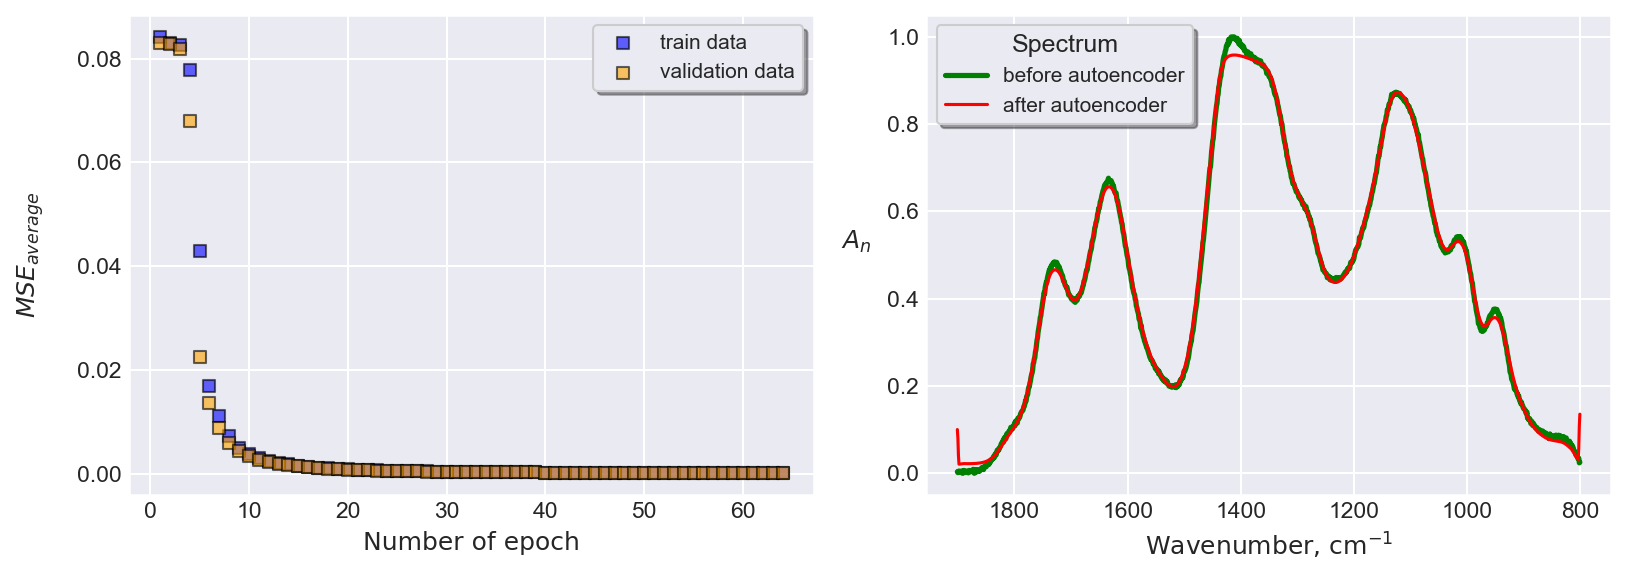

CPU times: user 4min 11s, sys: 27.5 s, total: 4min 39s
Wall time: 5min 40s


In [139]:
%%time

model = Autoencoder()

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model=model,
      train_loader=train_dataloader,
      val_loader=val_dataloader,
      loss_function=loss_function,
      optimizer=optimizer,
      X=wavenumber,
      plot_every_n_epoch=4,
      n_epochs=64,
      stop_criteria=None,
      path_to_save=path_to_save + '/nn_training.png'
     )

# Clustering on embeddings

## Class for clustering on embeddings

In [168]:
class EmbeddingStructureAnalysis():
    def __init__(self, model):
        self.model = model

    def get_embedding(self, torch_data):
        model = self.model
        _, embedding = model(torch_data)
        embedding = embedding.detach().numpy()[:, 0]
        embedding_df = pd.DataFrame(embedding)
        return embedding_df
    
    def fit_transform_kmeans(self, train_data, n_clusters, random_state=42):
        estimator = KMeans(n_clusters=n_clusters,
                           init='k-means++',
                           random_state=42)
        
        estimator.fit(train_data)       
        
        self.n_clusters = n_clusters
        self.train_data = train_data
        self.estimator = estimator
        self.cluster_centers = estimator.cluster_centers_
    
        predictions = pd.DataFrame(estimator.predict(train_data), index=train_data.index, columns=['Prediction'])
        self.predictions = predictions['Prediction']
        self.train_data_predictions = pd.concat([train_data, predictions], axis=1)
        
    def get_silhouette_score(self):
        train_data = self.train_data
        estimator = self.estimator
        if self.n_clusters >= 2:
            silhouette = silhouette_score(train_data, estimator.labels_)
        else:
            silhouette = None
        return silhouette

    def get_inertia(self):
        inertia = self.inertia
        return inertia

    def get_metric_in_range(self, metric='silhouette', max_n_clusters=None):
        train_data = self.train_data
        if max_n_clusters is None:
            max_n_clusters = train_data.shape[0] // 2
        n_clusters_arr = range(2, max_n_clusters+1)

        metric_values = []
        for n_clusters in tqdm(n_clusters_arr):
            self.fit_transform_kmeans(train_data=train_data, n_clusters=n_clusters)
            if metric == 'silhouette':
                value = self.get_silhouette_score()
            elif metric == 'inertia':
                value = self.get_inertia()
            metric_values.append(value)
        return metric_values

    def get_metrics_visualization(self, metric='silhouette', max_n_clusters=None, figsize=(11, 7.5), path_to_save=None, dpi=300):
        if max_n_clusters is None:
            max_n_clusters = self.train_data.shape[0] - 1
        
        n_clusters = list(range(2, max_n_clusters + 1))

        if metric == 'silhouette':
            metric_values = self.get_metric_in_range(metric='silhouette', max_n_clusters=max_n_clusters)
        elif metric == 'inertia':
            metric_values = self.get_metric_in_range(metric='inertia', max_n_clusters=max_n_clusters)

        qm_df_vis = pd.DataFrame(
            {
            'Number_of_clusters': n_clusters,
            'Value': metric_values
            }
        )
        
        sns.set_theme()

        fig = plt.figure(figsize=figsize, dpi=600, linewidth=1.0)
        
        ax = fig.gca()
        
        ax.grid(True)
        ax.tick_params(direction='in')
        
        bar = sns.barplot(data=qm_df_vis,
                          x='Number_of_clusters',
                          y='Value',
                          palette='mako',
                          ax=ax)

        ax.set_ylabel('Metric value',
                      fontstyle='normal',
                      fontsize=16,
                      rotation=90,
                      labelpad=5)
        
        ax.set_xlabel('Number of clusters',
                      fontstyle='normal',
                      fontsize=16,
                      rotation=0,
                      labelpad=5)
        
        bar.set_xticklabels(bar.get_xticklabels(), rotation=0, fontsize=16)
        
        plt.tight_layout()

        if path_to_save is not None:
            plt.savefig(path_to_save, dpi=dpi)
        plt.show()

    def get_spectra_clusters_visualization(self, data, wavenumber, n_clusters, nrows, ncols, figsize=(10, 6), color='dodgerblue', path_to_save=None, dpi=300):
        self.fit_transform_kmeans(train_data=data, n_clusters=n_clusters)
        data_with_labels = self.train_data_predictions
        centroids = self.cluster_centers

        fig = plt.figure(figsize=figsize, dpi=600)
        
        for i in range(n_clusters):
            temp_data = data_with_labels.loc[data_with_labels['Prediction'] == i].iloc[:, :-1].to_numpy()
            temp_centroid = centroids[i]
        
            ax = plt.subplot(nrows, ncols, i+1)
            
            for spectrum in temp_data:
                ax.plot(wavenumber, spectrum, linewidth=1.5, color=color)
        
            ax.plot(wavenumber, temp_centroid, linestyle='--', linewidth=2.0, color='black', label='Centroid')
        
            ax.set_xlabel('Wavenumber, cm$^{-1}$', fontstyle='normal', fontsize=12, labelpad=5)
            ax.set_ylabel('A', fontstyle='italic', fontsize=12, labelpad=15, rotation=0)
        
            ax.invert_xaxis()
        
            ax.legend()

        plt.tight_layout()
        
        if path_to_save is not None:
            plt.savefig(path_to_save, dpi=dpi)
        plt.show()

## Clustering

In [61]:
path_to_save = './../../results/ftir/clustering_autoencoder'

### *GO*

100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.12it/s]


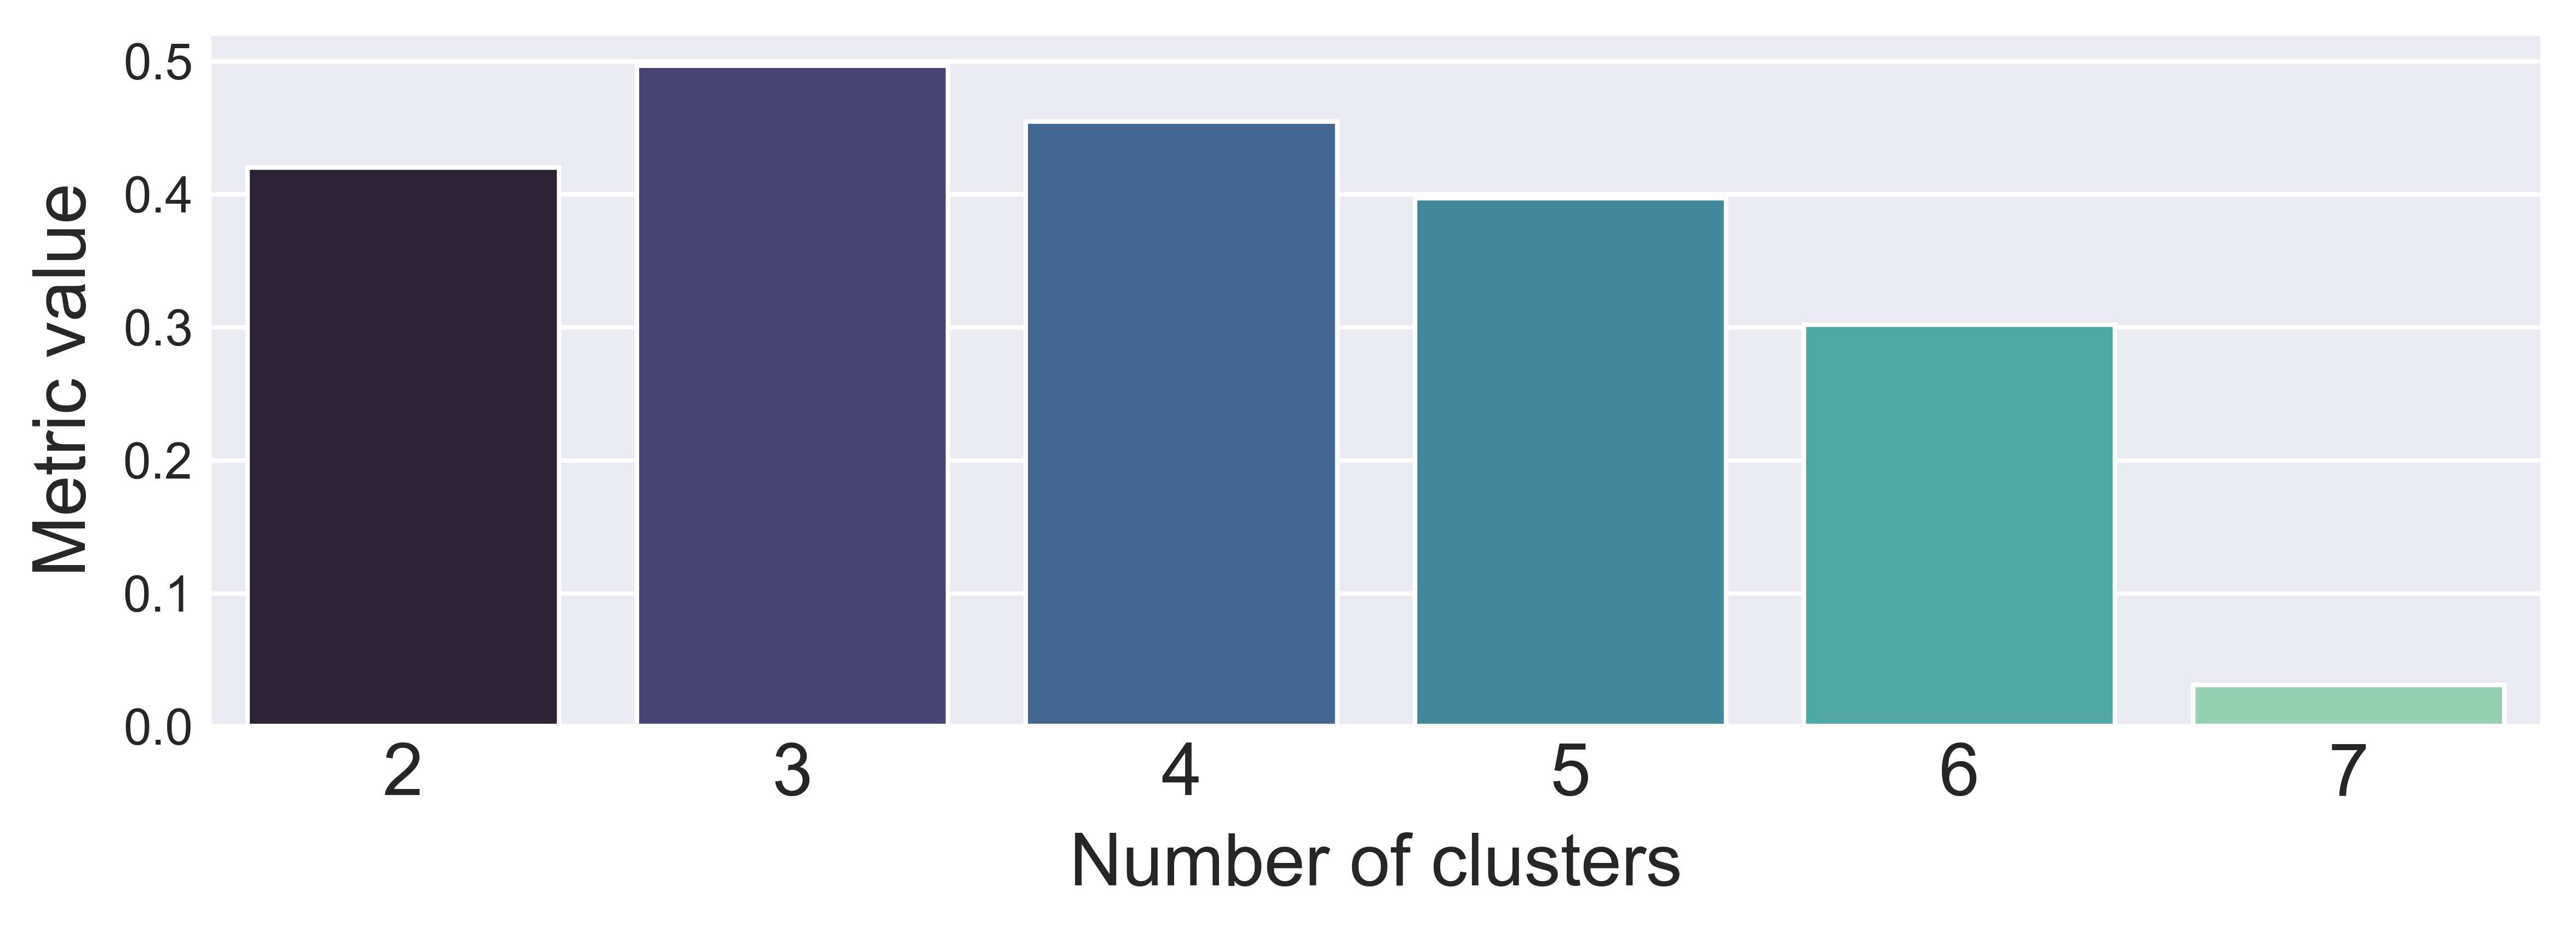

In [186]:
analyzer = EmbeddingStructureAnalysis(model=model)

emebedding = analyzer.get_embedding(go_data_torch)

analyzer.fit_transform_kmeans(train_data=emebedding, n_clusters=2)
analyzer.get_metrics_visualization(metric='silhouette', figsize=(8, 3), path_to_save=path_to_save + '/go_metrics.png', dpi=600)

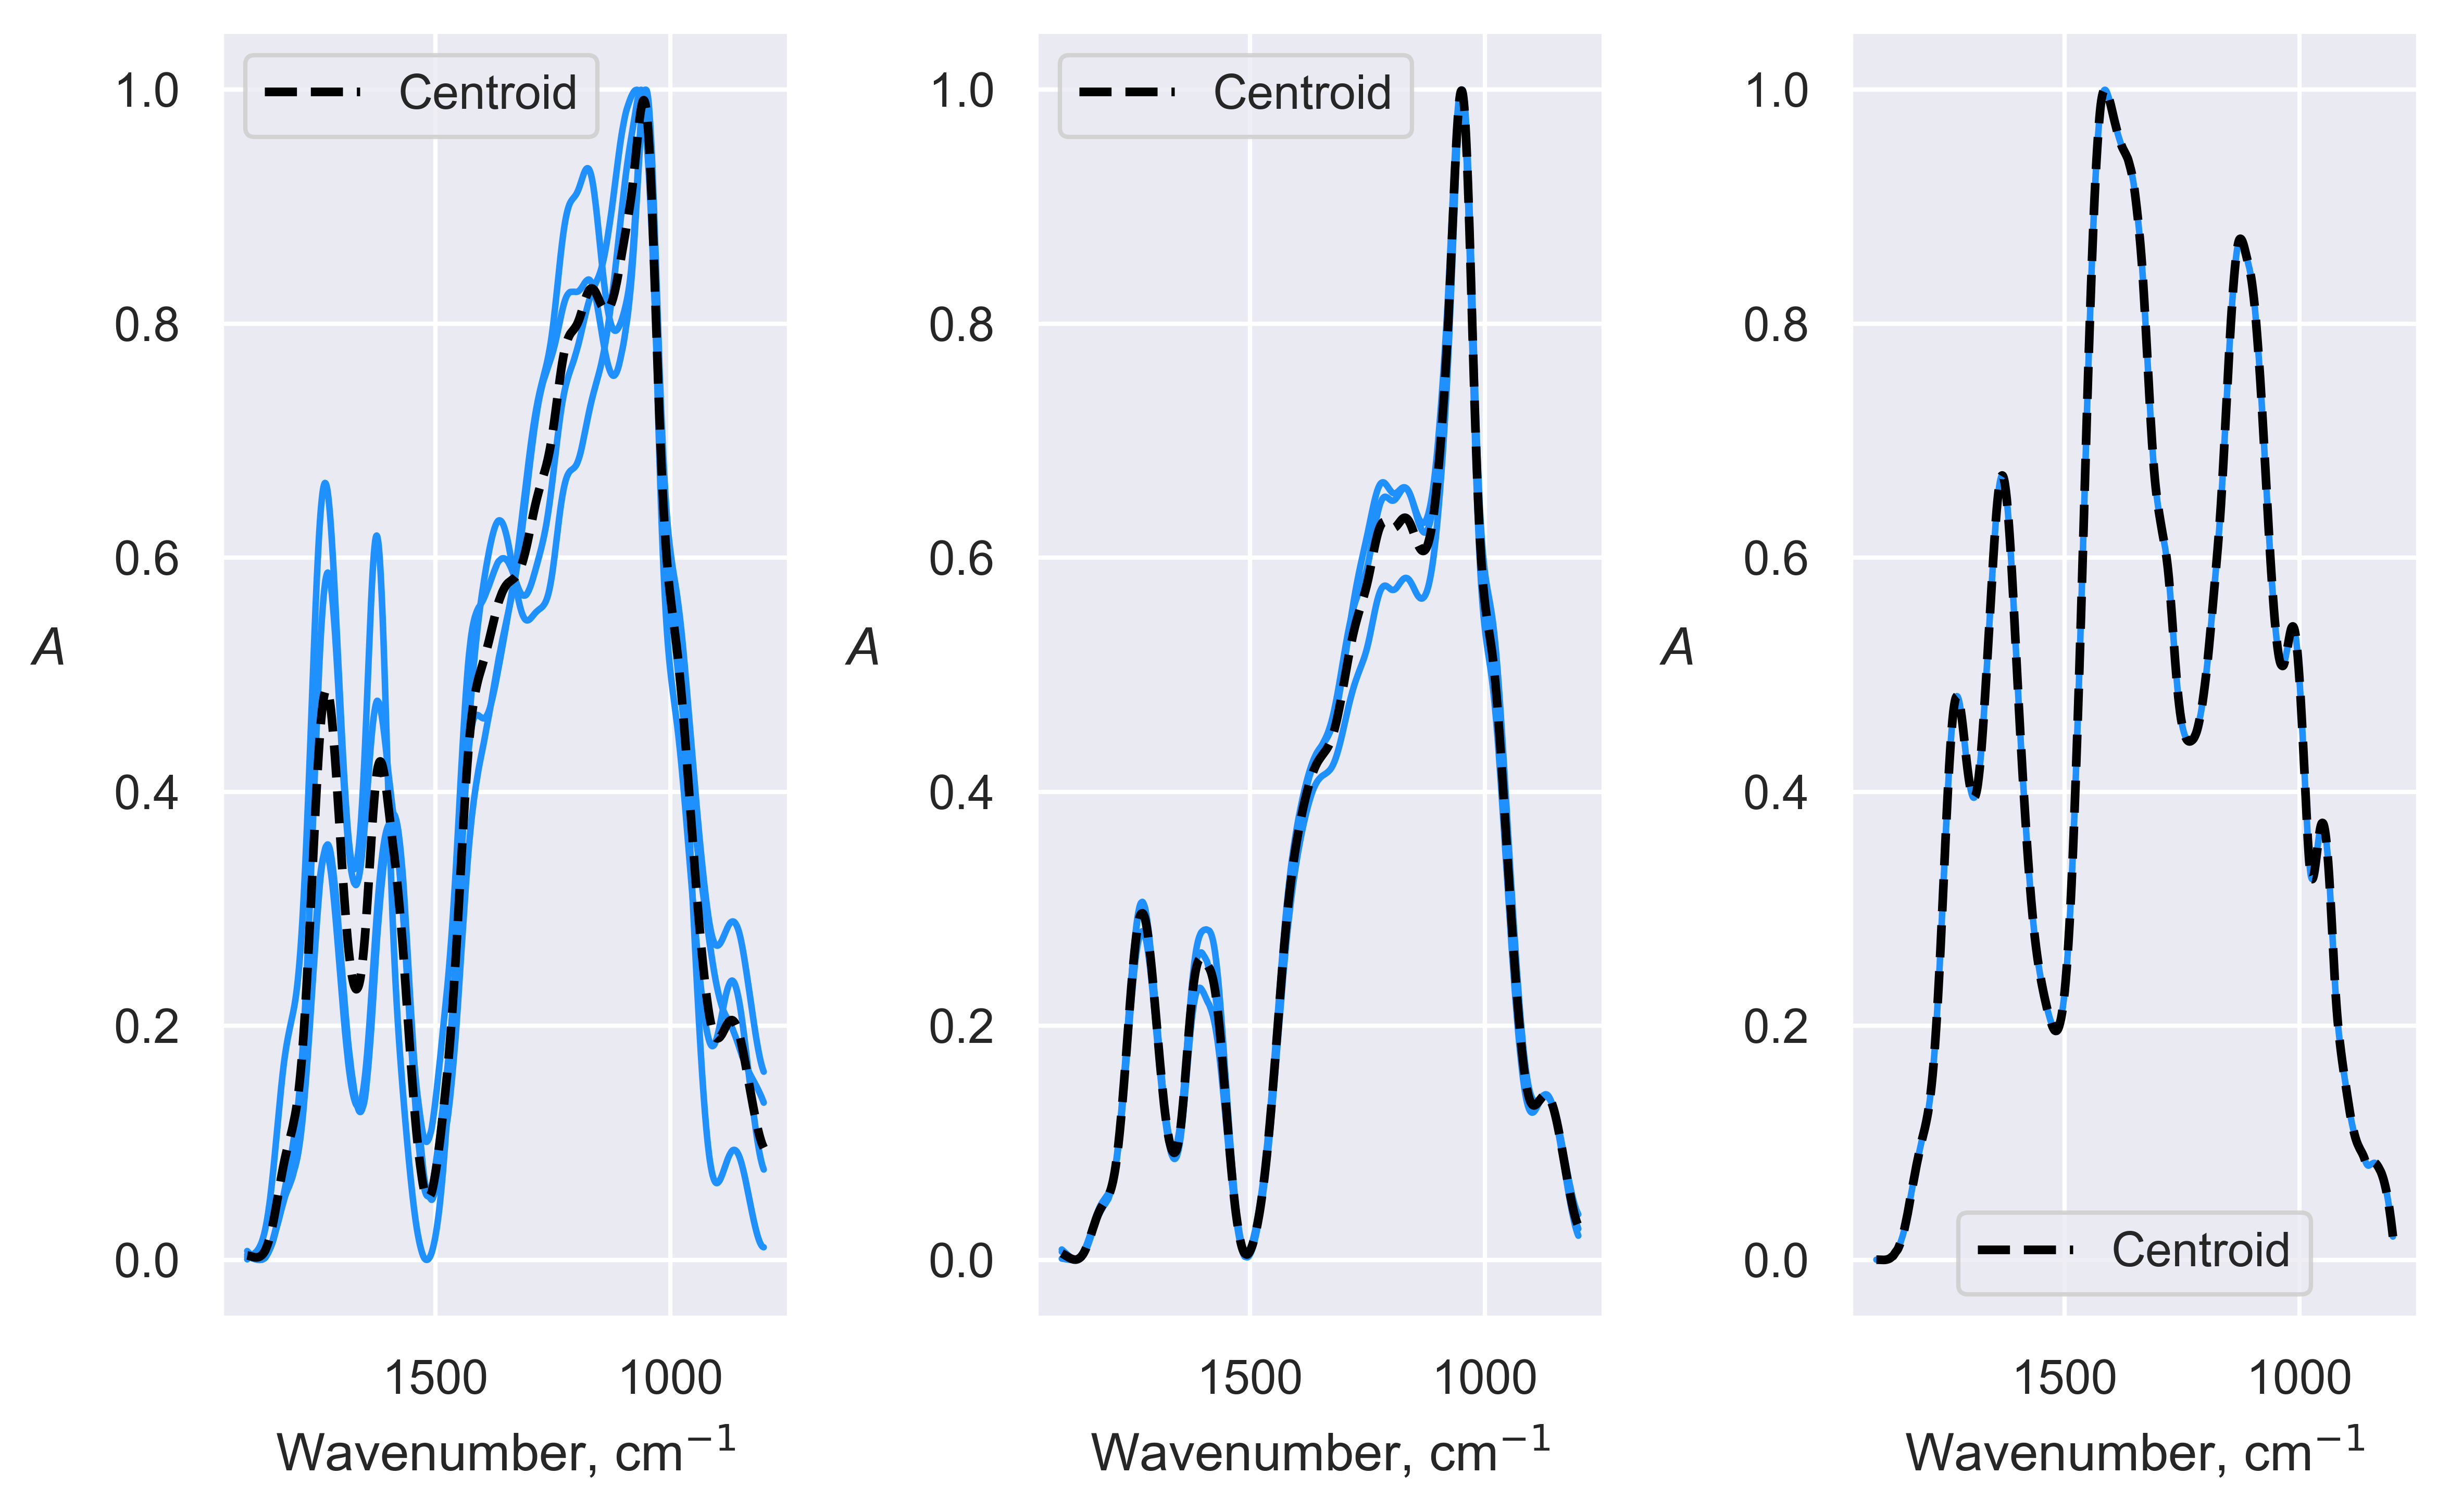

In [190]:
analyzer.get_spectra_clusters_visualization(data=go_data, wavenumber=wavenumber, n_clusters=3,
                                            ncols=3, nrows=1, figsize=(8, 5), color='dodgerblue',
                                            path_to_save=path_to_save + '/go_clusters.png', dpi=600)

### *rGO*

100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.71it/s]


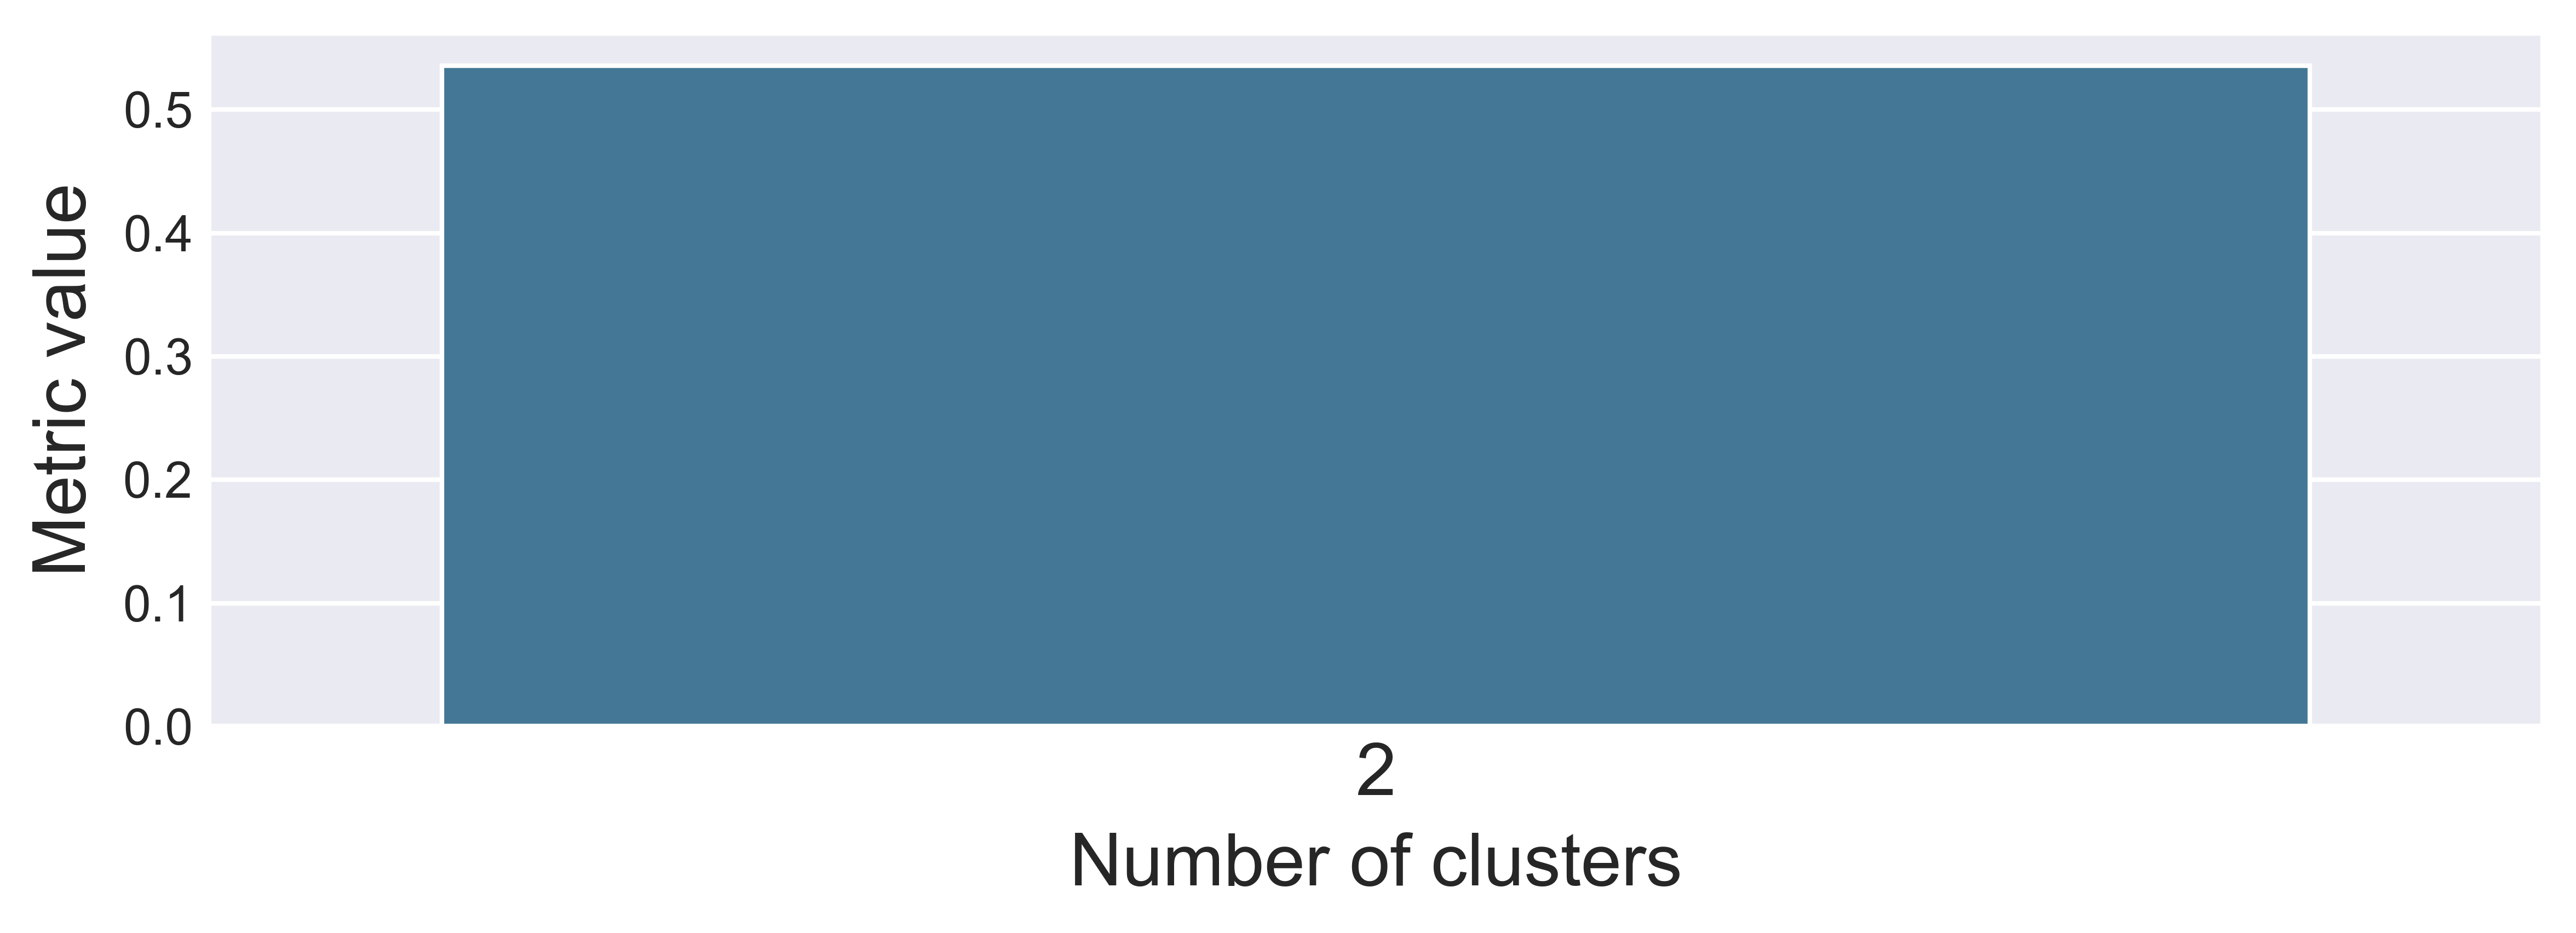

In [191]:
analyzer = EmbeddingStructureAnalysis(model=model)

emebedding = analyzer.get_embedding(rgo_data_torch)

analyzer.fit_transform_kmeans(train_data=emebedding, n_clusters=2)
analyzer.get_metrics_visualization(metric='silhouette', figsize=(8, 3), path_to_save=path_to_save + '/rgo_metrics.png', dpi=600)

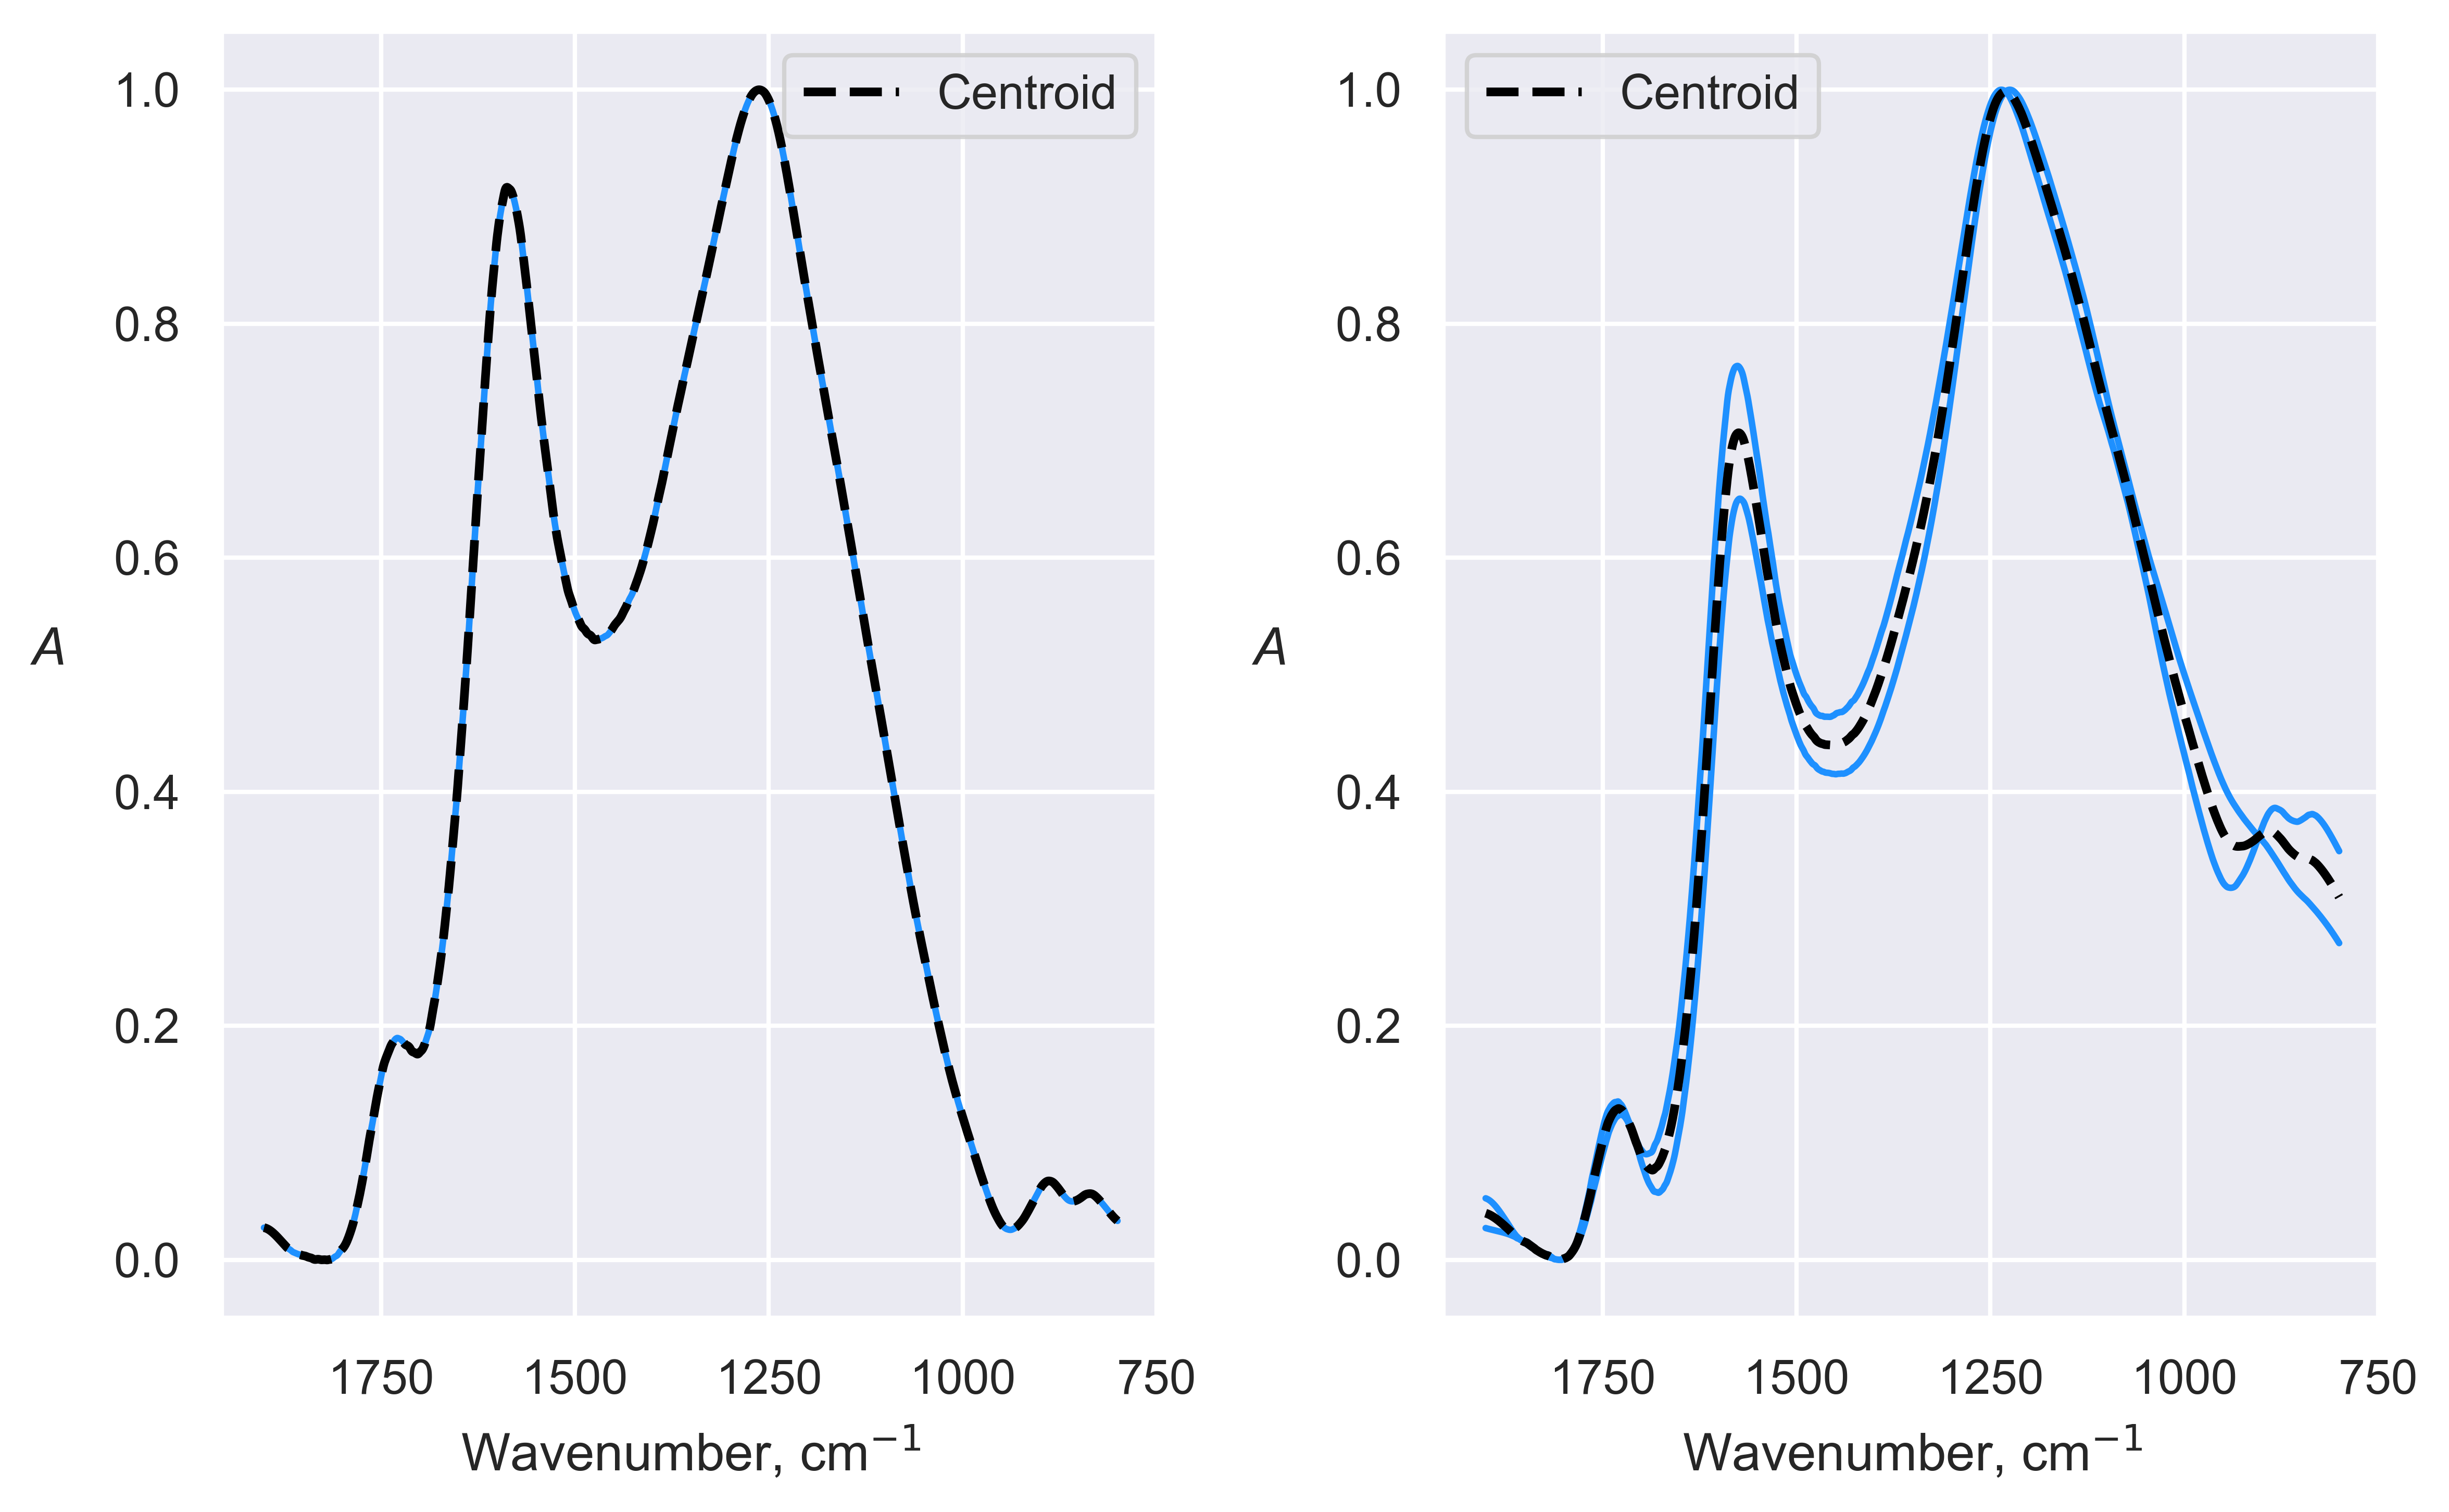

In [195]:
analyzer.get_spectra_clusters_visualization(data=rgo_data, wavenumber=wavenumber, n_clusters=2,
                                            ncols=2, nrows=1, figsize=(8, 5), color='dodgerblue',
                                            path_to_save=path_to_save + '/rgo_clusters.png', dpi=600)

### $GO_{d}$

100%|█████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.88it/s]


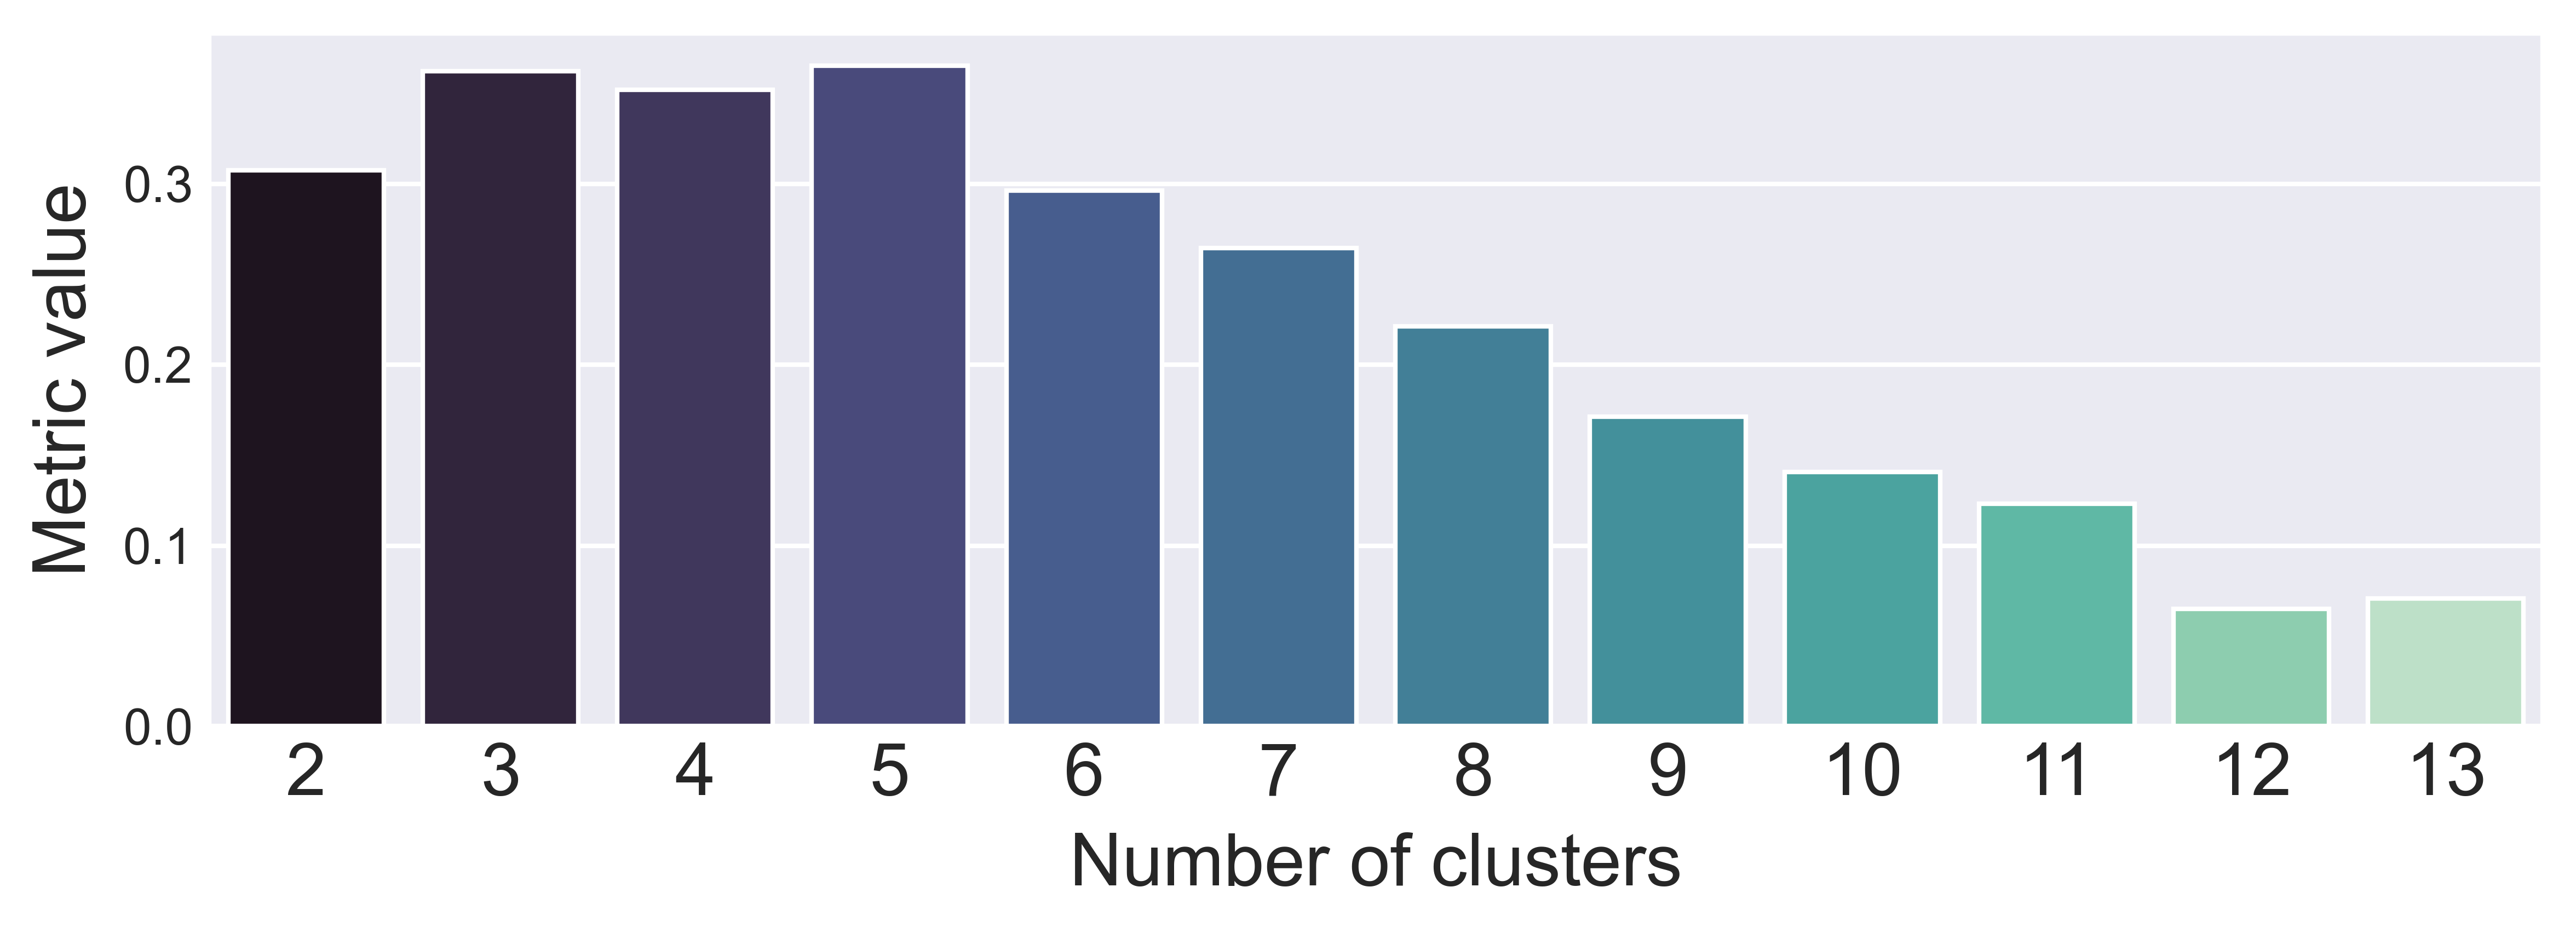

In [193]:
analyzer = EmbeddingStructureAnalysis(model=model)

emebedding = analyzer.get_embedding(god_data_torch)

analyzer.fit_transform_kmeans(train_data=emebedding, n_clusters=2)
analyzer.get_metrics_visualization(metric='silhouette', figsize=(8, 3), path_to_save=path_to_save + '/god_metrics.png', dpi=600)

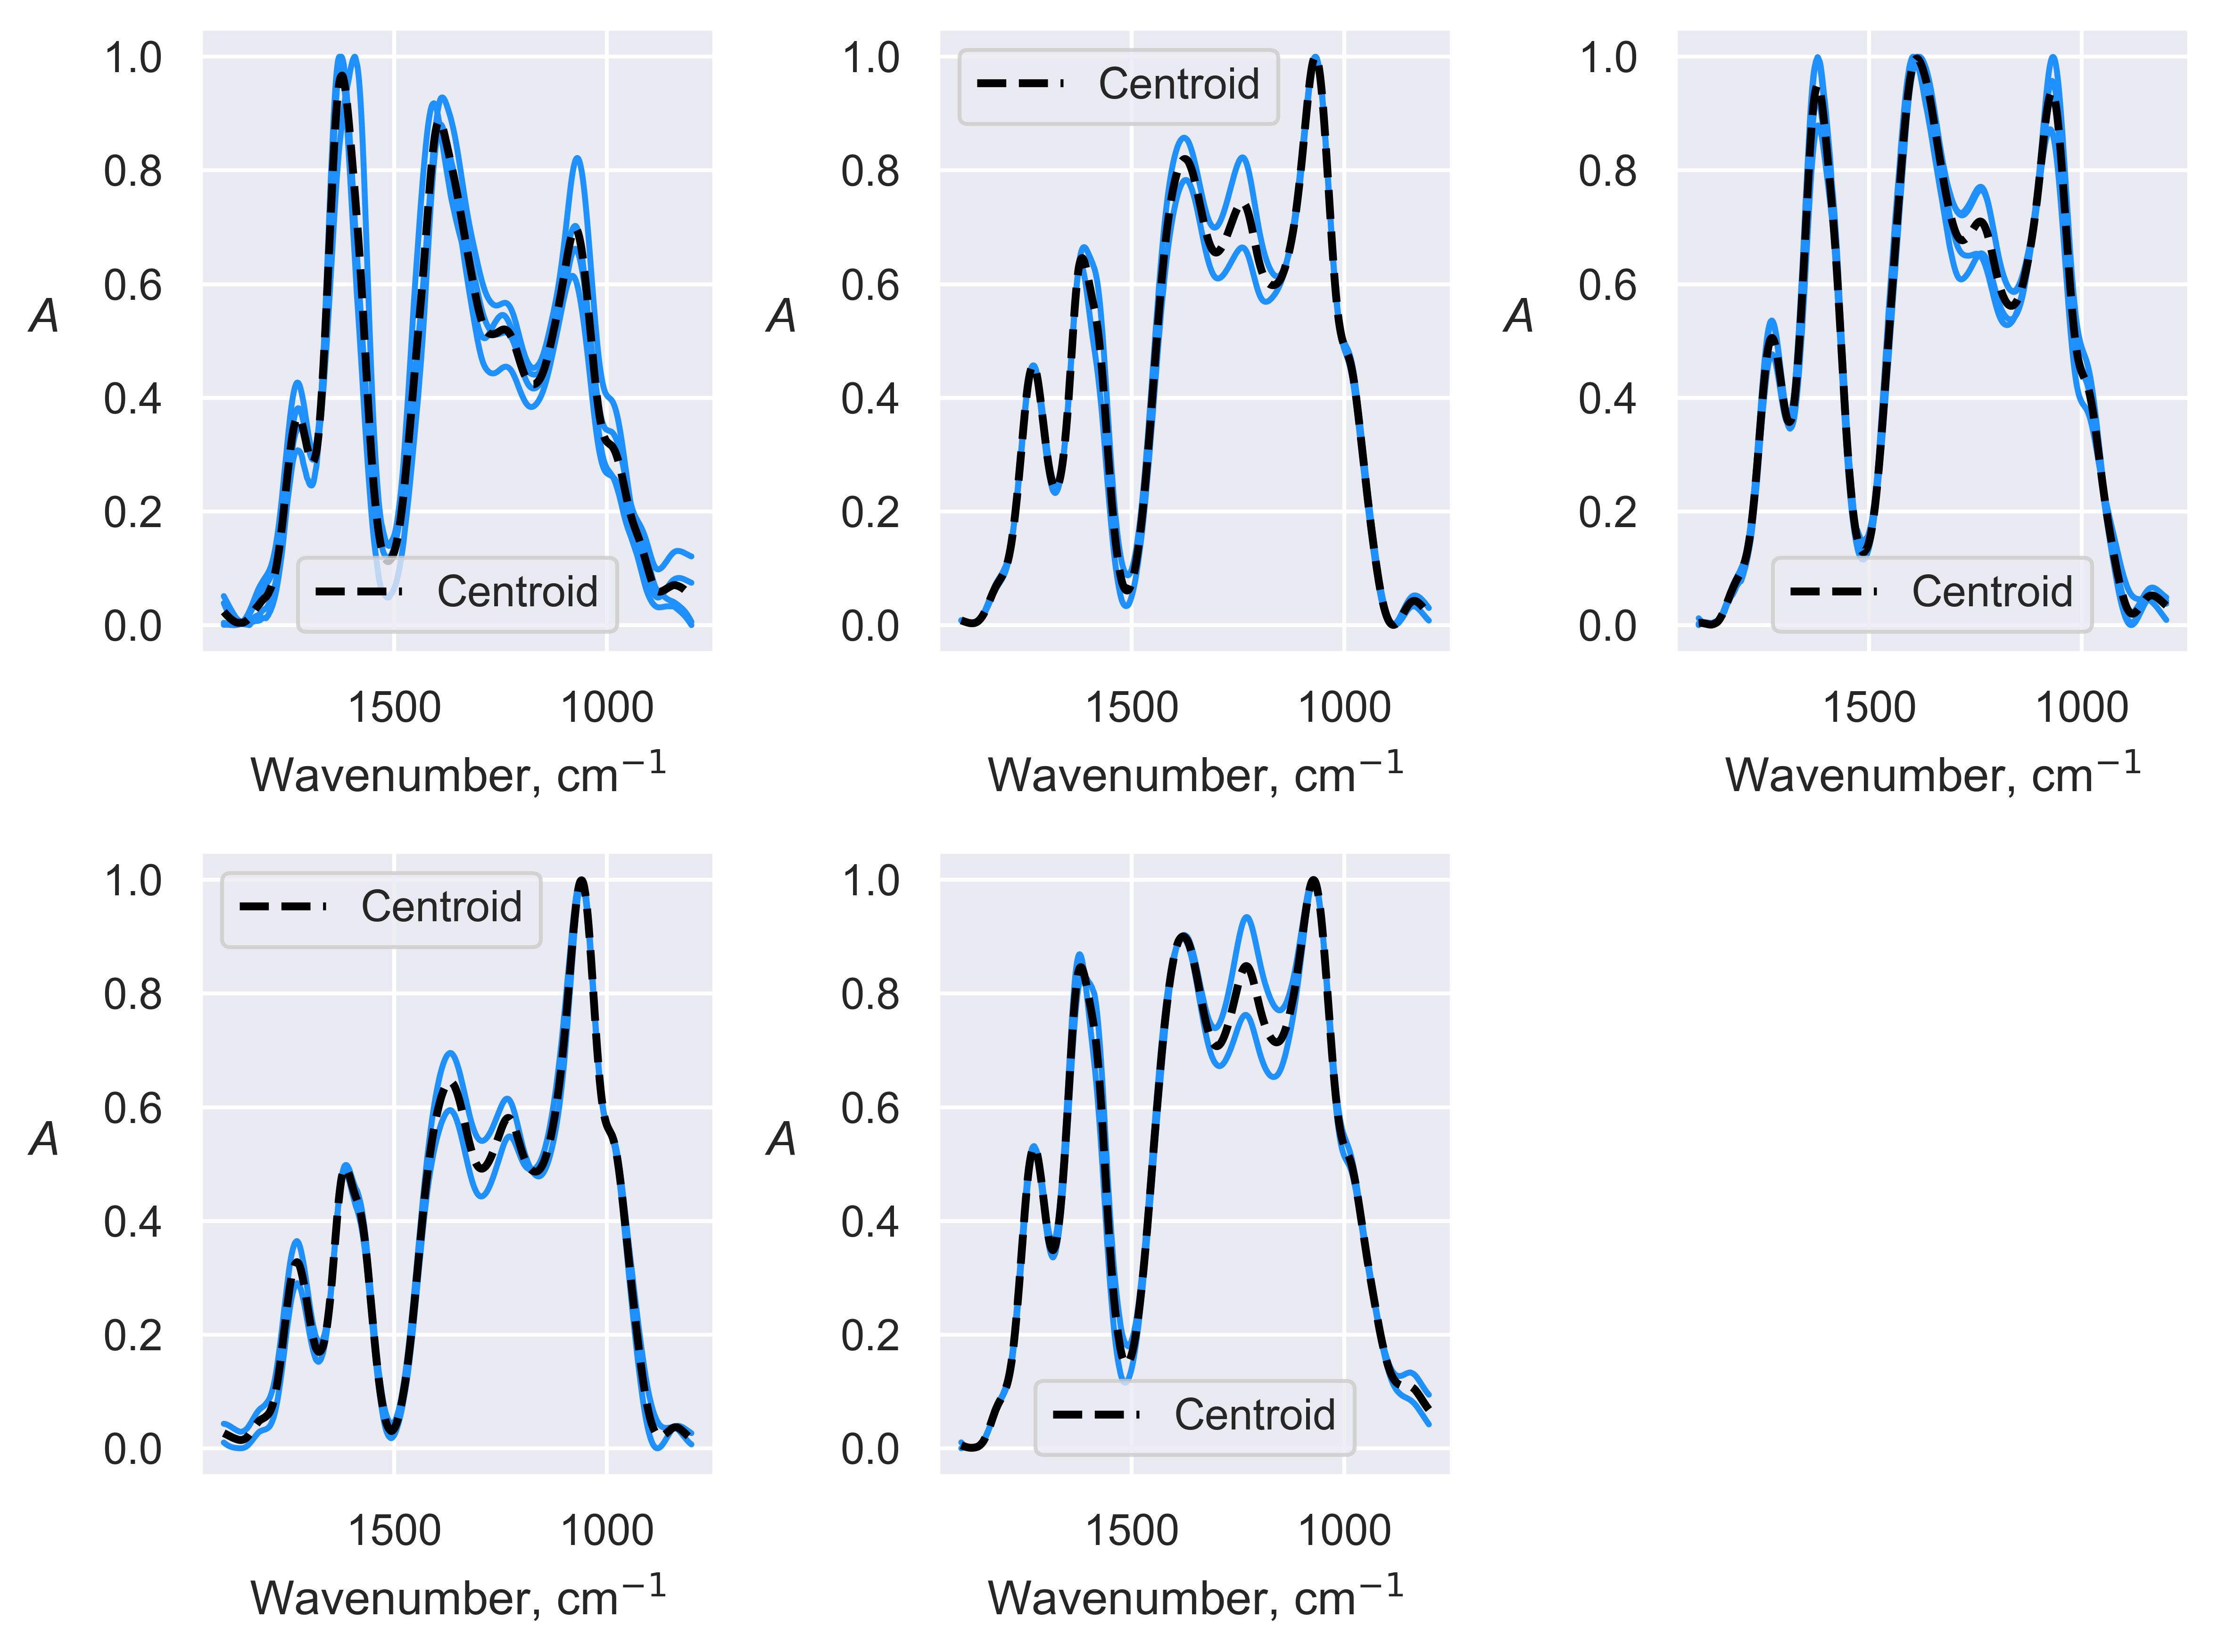

In [198]:
analyzer.get_spectra_clusters_visualization(data=god_data, wavenumber=wavenumber, n_clusters=5,
                                            ncols=3, nrows=2, figsize=(8, 6), color='dodgerblue',
                                            path_to_save=path_to_save + '/god_clusters.png', dpi=600)